# Investigate DWPC transformation

In [1]:
library(dplyr, warn = F)

In [2]:
feature_df = readr::read_tsv('data/matrix/hetio-ind/features.tsv.bz2')
summary_df = readr::read_tsv('data/auroc.tsv')

In [3]:
# Select random features, stratefied by nonzero percentage
dist_df = summary_df %>%
  dplyr::filter(feature_type == 'DWPC' & fdr_pval_auroc <= 0.01) %>%
  dplyr::mutate(nonzero_quantile = dplyr::ntile(nonzero, 5)) %>%
  dplyr::group_by(nonzero_quantile) %>%
  dplyr::sample_n(3) %>%
  dplyr::arrange(nonzero) %>%
  dplyr::select(feature, nonzero, nonzero_quantile)

Joining by: "feature"
Saving 7 x 7 in image


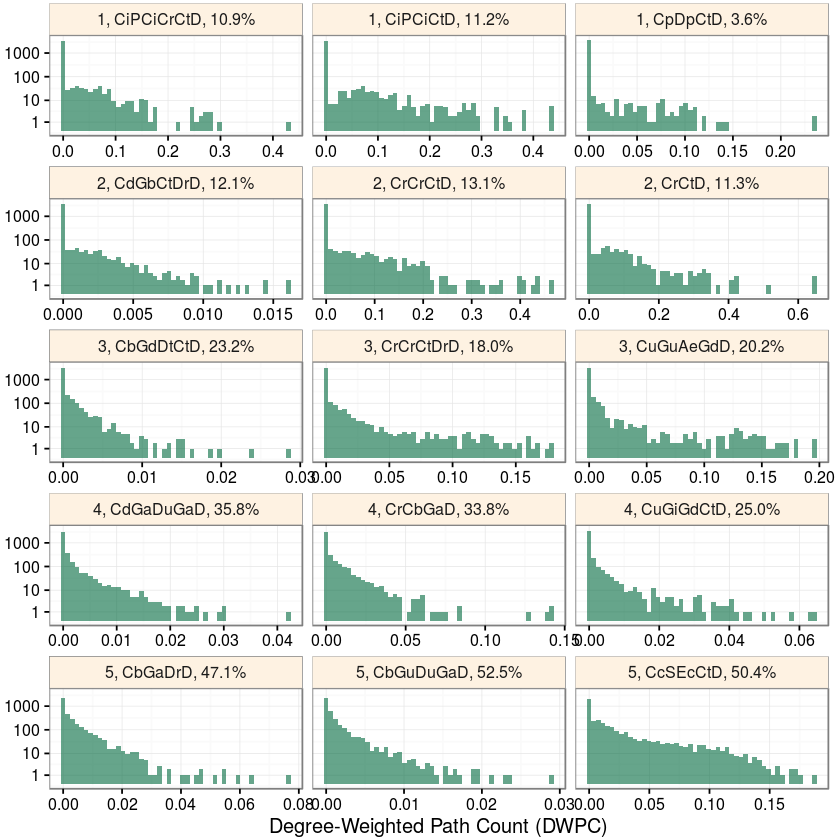

In [4]:
# Plot DWPC distributions
ihs_scale = scales::trans_new(name = 'ihs', transform = asinh, inverse = sinh)

set.seed(0)

gg_dist = feature_df %>%
  dplyr::select(one_of(dist_df$feature)) %>%
  tidyr::gather(key = feature, value = value) %>%
  dplyr::inner_join(dist_df) %>%
  dplyr::mutate(nonzero = scales::percent(nonzero)) %>%
  ggplot2::ggplot(ggplot2::aes(x = value)) +
  ggplot2::facet_wrap(nonzero_quantile ~ feature + nonzero, ncol = 3, scales='free_x',
        labeller = ggplot2::as_labeller(I, multi_line = F)) +
  ggplot2::geom_histogram(bins = 50, alpha = 0.6, fill = '#00693E') +
  ggplot2::theme_bw() +
  ggplot2::theme(strip.background=ggplot2::element_rect(fill='#FEF2E2')) +
  ggplot2::theme(plot.margin=grid::unit(c(2, 7, 2, 2), 'points')) +
  ggplot2::scale_y_continuous(trans = ihs_scale, breaks = c(1, 10, 100, 1000, 10000)) +
  ggplot2::xlab('Degree-Weighted Path Count (DWPC)') + ggplot2::ylab(NULL)

ggplot2::ggsave('media/DWPC-distribution.png', gg_dist, dpi = 175)
plot(gg_dist)

## Inverse hyperbolic sine transformation

In [5]:
ihs_transform <- function(x, theta = 1) {
  # Inverse Hyperbolic Sine transformation
  return(asinh(theta * x) / theta)
}

transform_dwpc <- function(x) {
  # Transform a DWPC (degree-weighted path count)
  x_mean = mean(x)
  theta = x_mean ^ -1
  return(ihs_transform(x, theta = theta) / x_mean)
}